In [6]:
from sklearn import datasets
import numpy as np
import pandas as pd
import heapq
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### داده ها خوانده میشود و داخل دیتافریم ریخته میشود

In [7]:
mnist = datasets.load_digits()
mod_mnist = np.array(mnist.data)
mod_mnist = mod_mnist.T

In [8]:
pd_mnist = pd.DataFrame(mnist.data)
pd_mnist['actual'] = mnist.target

### داده های آموزش تست و ارزیابی معادل train و dev و test تقسیم میشوند. با نسبت 70 و 20 و 10. 

In [9]:
def train_dev_test_split(data):
    m = len(data)
    train = data.iloc[0:int(0.7*m), :]
    dev = data.iloc[int(0.7*m):int(0.9*m), :]
    test = data.iloc[int(0.9*m): , :]
    return train, dev, test

### فاصله منهتن و فاصله اقلیدسی در دو تابع زیر حساب میشوند

In [10]:
def manhatan_distance(row1, row2):
    return np.sum(np.abs(row1 - row2))
def euclidean_distance(row1, row2):
    distance = 0.0
    dist = np.sum((row1 - row2)**2)
    return np.sqrt(dist)

### k  نزدیک ترین همسایه با توجه به نوع فاصله داده شده مقایسه میشود 

In [11]:
def get_neighbors(raw_train, row, k, is_manhatan):
    distances = {}
    train = raw_train[:, 0:-1]
#     row = raw_row[0:-1]
    for i in range(len(train)):
        if is_manhatan:
            distances[i] = manhatan_distance(train[i], row)
        else:
            distances[i] = euclidean_distance(train[i], row)
#     sorted_dic = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
    result_dic = heapq.nsmallest(k, distances.items(), key=lambda i: i[1])
    result_rows = []
    for i in result_dic:
        result_rows.append(raw_train[i[0]])
    
    return result_rows
    

In [12]:
row1 = np.squeeze(np.array([1,2,3,4,5]))
row2 = np.squeeze(np.array([21,22,23,24,25,10]))
row3 = np.squeeze(np.array([11,12,13,14,15,100]))
row4 = np.squeeze(np.array([11,21,31,41,51, 0]))
print(get_neighbors(np.array([row2, row3, row4]), row1, True, 1))

[array([ 11,  12,  13,  14,  15, 100])]


### بیشترین برچسب بینkهمسایه نزدیک پیدا میشود 

In [13]:
def predict_value(raw_neighbors):
    neighbors = np.array(raw_neighbors)
    values = neighbors[:, -1]
    return stats.mode(values)[0][0]

In [14]:
row2 = np.squeeze(np.array([21,22,23,24,25,1]))
row3 = np.squeeze(np.array([11,12,13,14,15,3]))
row4 = np.squeeze(np.array([11,21,31,41,51, 2]))
print(predict_value(np.array([row2, row3, row4])))


1


### داده های آموزشی و یک داده تست گرفته میشود و با توجه به k و نوع فاصله برچسب آن تشخیص داده میشود 

In [15]:
def prediction_with_knn(train, row, k, is_manhattan):
    nearest_neighbors = get_neighbors(train, row, k, is_manhattan)
    predicted_value = predict_value(nearest_neighbors)
    return predicted_value

## با توجه به نتایج پایین به این نتیجه میرسیم که k=3 با فاصله اقلیدسی بهترین دقت را میدهد. خطا 0.01

In [16]:
shuffle_data = pd_mnist.sample(frac=1).reset_index(drop=True)
train_data, dev_data, test_data= train_dev_test_split(shuffle_data)
errors = {}
curr_data =dev_data.copy()
m_data = len(curr_data)
for i in [False, True]:
    for k in [1,3,5,7,9,11]:
        correct = 0.0
        for index, raw_row in curr_data.iterrows():
            row = raw_row.to_numpy()
            predicted= prediction_with_knn(train_data.to_numpy(), row[:-1], k, i)
            if predicted == row[-1]:
                correct += 1
        print('correct', correct)
        errors['k:' + str(k) + ' is_manhatan: ' + str(i)] = (m_data-correct)/m_data
        print('k:' + str(k) + ' is_manhatan: ' + str(i)+ ": ", errors['k:' + str(k) + ' is_manhatan: ' + str(i)])
print(errors)


correct 355.0
k:1 is_manhatan: False:  0.013888888888888888
correct 356.0
k:3 is_manhatan: False:  0.011111111111111112
correct 356.0
k:5 is_manhatan: False:  0.011111111111111112
correct 353.0
k:7 is_manhatan: False:  0.019444444444444445
correct 356.0
k:9 is_manhatan: False:  0.011111111111111112
correct 355.0
k:11 is_manhatan: False:  0.013888888888888888
correct 354.0
k:1 is_manhatan: True:  0.016666666666666666
correct 355.0
k:3 is_manhatan: True:  0.013888888888888888
correct 354.0
k:5 is_manhatan: True:  0.016666666666666666
correct 354.0
k:7 is_manhatan: True:  0.016666666666666666
correct 353.0
k:9 is_manhatan: True:  0.019444444444444445
correct 353.0
k:11 is_manhatan: True:  0.019444444444444445
{'k:1 is_manhatan: False': 0.013888888888888888, 'k:3 is_manhatan: False': 0.011111111111111112, 'k:5 is_manhatan: False': 0.011111111111111112, 'k:7 is_manhatan: False': 0.019444444444444445, 'k:9 is_manhatan: False': 0.011111111111111112, 'k:11 is_manhatan: False': 0.01388888888888

### تابع اصلی knn است که در یک مجموعه آموزش و یک مجموعه تست، نوع فاصله، مقدار k، داده ای که باید چاپ شود و اینکه آیا از مدل آماده sklearn استفاده شود یا خیر گرفته میشود و نتایج را با توجه به این ها از قبیل دقت و ماتریس پریشانی چاپ میکند

In [30]:
def main_knn(knn_train_data, knn_test_data, k, is_manhatta, show_data, print_flag = True, with_sklearn = False, sklearn_knn = None):
    curr_data = knn_test_data.copy()
    m_data = len(curr_data)
    correct = 0
    total_predictions = []
    for index, raw_row in curr_data.iterrows():
        row = raw_row.to_numpy()
        if not with_sklearn:
            predicted= prediction_with_knn(knn_train_data.to_numpy(), row[:-1], k, is_manhatta)
        else:
            predicted = sklearn_knn.predict([row[:-1]])
        if predicted == row[-1]:
            correct += 1
        total_predictions.append(predicted)
    knn_error = (m_data - correct)/m_data
    if print_flag:
        print(str(show_data) + str(knn_error))
        print(confusion_matrix(curr_data.iloc[:, -1].to_numpy(), total_predictions, labels=range(10)))
    return curr_data.iloc[:, -1].to_numpy(), total_predictions
    
    

In [26]:
main_knn(train_data, train_data, 3,False, "training error: ")
main_knn(train_data, dev_data, 3, False, "dev error: ")
main_knn(train_data, test_data, 3, False, "test error: ")
print('')

training error: 0.003977724741447892
[[129   0   0   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0]
 [  0   0 126   0   0   0   0   0   0   0]
 [  0   0   0 123   0   0   0   0   0   0]
 [  0   0   0   0 126   0   0   0   0   0]
 [  0   0   0   0   0 127   1   0   0   0]
 [  0   0   0   0   0   0 125   0   0   0]
 [  0   0   0   0   0   0   0 123   0   0]
 [  0   1   0   0   0   0   0   0 122   0]
 [  0   0   0   1   0   1   0   0   1 122]]
dev error: 0.011111111111111112
[[34  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  1  0  0]
 [ 0  1  0  0 35  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  1]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0]
 [ 0  1  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 38]]
test error: 0.027777777777777776
[[15  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0]
 [ 0

### مقادیر پیش بینی شده و مقادیر واقعی و پیکس ها را میگیرد و با توجه به آن شکل را مانند زیر رسم میکند.

In [27]:
def show_graph(raw_pixels, y_org, y_pred):
    fig, axis = plt.subplots(10, 10)
    column_counter = 0
    for i in range(len(raw_pixels)):
        row = raw_pixels[i, :-1]
        pixels = row.reshape(8, 8)
        column_counter = column_counter % 10
        axis[int(i/10), column_counter].imshow(pixels, cmap='gray')
        axis[int(i/10), column_counter].set_title('y_org:'+ str(y_org[i])+ ', y_pred:' + str(int(y_pred[i])) )
        column_counter += 1
        fig.set_size_inches(22.5, 15.5)
    plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.5,
                    hspace=0.85)
    plt.show()

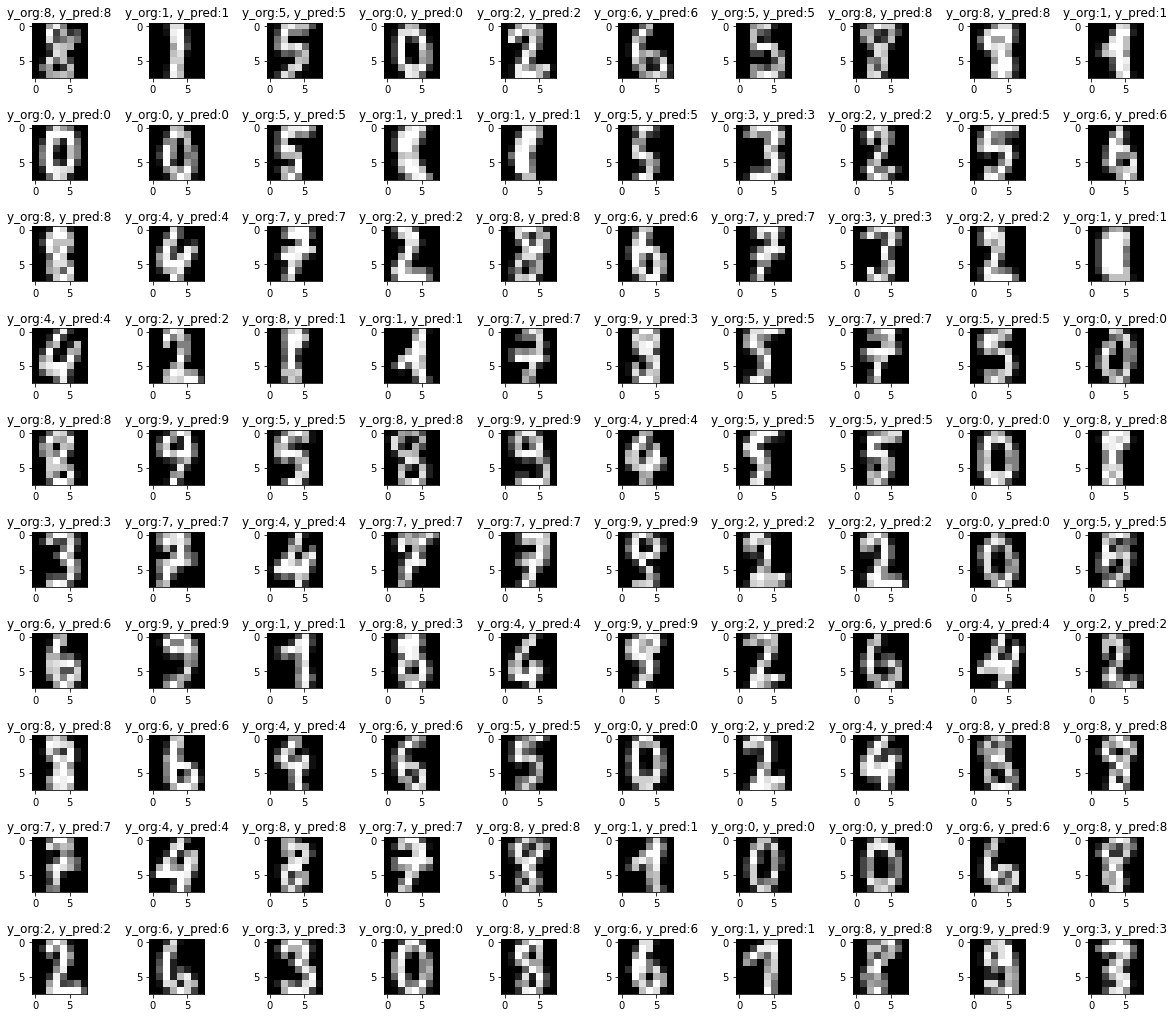

In [28]:
test_sample = test_data.iloc[0:100, :]
sample_org, sample_pred = main_knn(train_data, test_sample, 3, False, False, False)
show_graph(test_sample.to_numpy(), sample_org, sample_pred)

### یکبار الگوریتم با استفاده از مدل آماده در sklearn انجام میشود و نتایج آن در پایین آمده است

sklearn training error: 0.003977724741447892
[[129   0   0   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   0   0]
 [  0   0 126   0   0   0   0   0   0   0]
 [  0   0   0 123   0   0   0   0   0   0]
 [  0   0   0   0 126   0   0   0   0   0]
 [  0   0   0   0   0 127   1   0   0   0]
 [  0   0   0   0   0   0 125   0   0   0]
 [  0   0   0   0   0   0   0 123   0   0]
 [  0   1   0   0   0   0   0   0 122   0]
 [  0   0   0   1   0   1   0   0   1 122]]
sklearn dev error: 0.011111111111111112
[[34  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  1  0  0]
 [ 0  1  0  0 35  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  1]
 [ 0  0  0  0  0  0 38  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0]
 [ 0  1  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 38]]
sklearn test error: 0.027777777777777776
[[15  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0 13

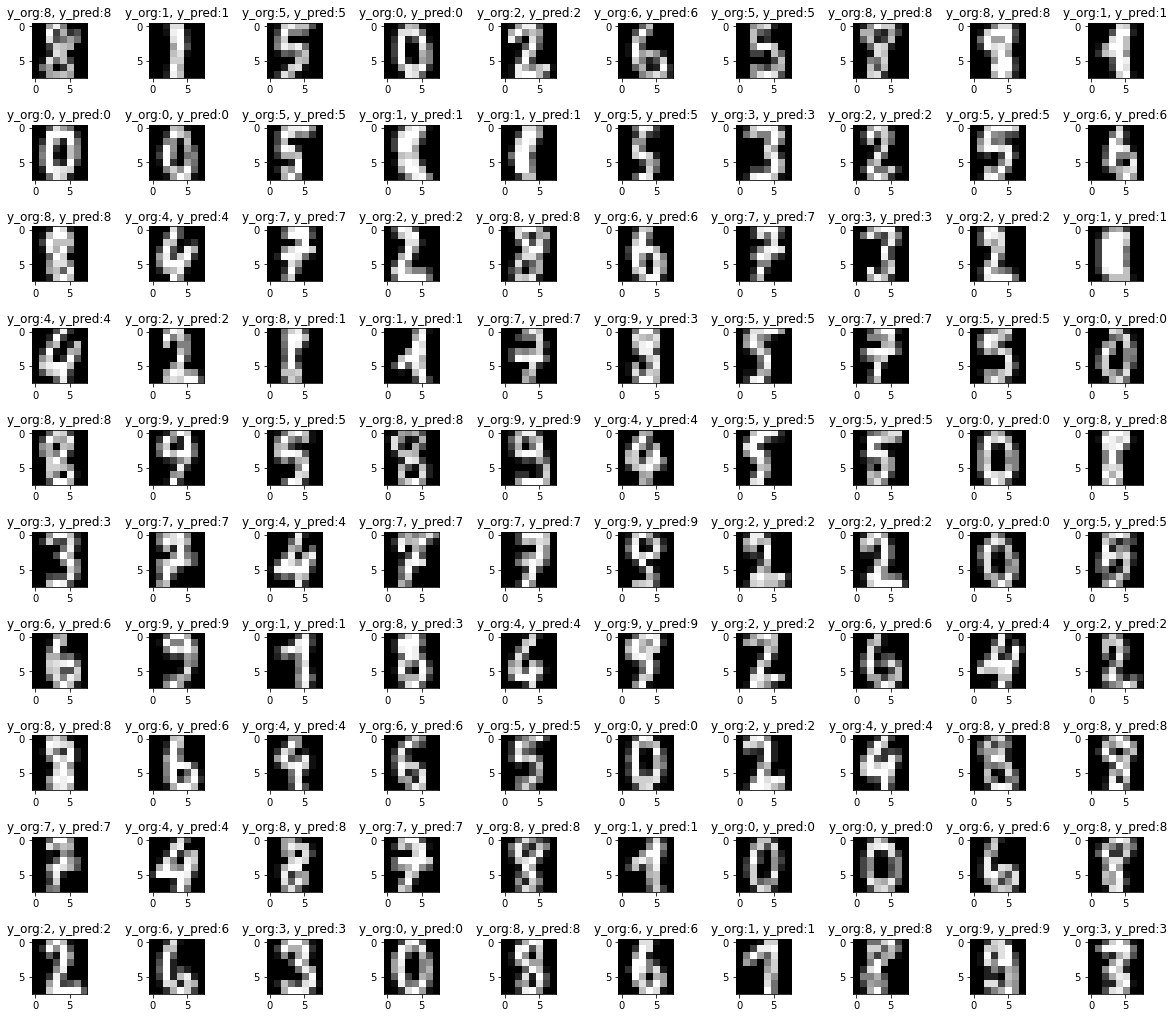

In [31]:
knn =  KNeighborsClassifier(n_neighbors=3)
X = train_data.to_numpy()[:,:-1]
y = train_data.to_numpy()[:,-1]
knn.fit(X, y)
# sklearn_errors = {}
# correct = 0
# for index, raw_row in curr_data.iterrows():
#     row = raw_row.to_numpy()
#     predicted= knn.predict([row[:-1]])
#     if predicted == row[-1]:
#         correct += 1
# print('correct', correct)
# sklearn_errors['k:' + str(k) + ' is_manhatan: ' + str(i)] = (m_data-correct)/m_data
main_knn(train_data, train_data, 3,False, "sklearn training error: ", True, True, knn)
main_knn(train_data, dev_data, 3, False, "sklearn dev error: ", True, True, knn)
main_knn(train_data, test_data, 3, False, "sklearn test error: ", True, True, knn)
sample_org, sample_pred = main_knn(train_data, test_sample, 3, False, False, False, True, knn )
show_graph(test_sample.to_numpy(), sample_org, sample_pred)


## همانطور که مشاهده میشود نتایج مانند هم هستند